In [19]:
import networkx as nx
from dowhy import gcm
from dowhy.utils import plot, bar_plot
import warnings
warnings.filterwarnings("ignore")

In [4]:
import networkx as nx
from dowhy import gcm
from dowhy.utils import plot, bar_plot

causal_graph = nx.DiGraph([('www', 'Website'),
                           ('Auth Service', 'www'),
                           ('API', 'www'),
                           ('Customer DB', 'Auth Service'),
                           ('Customer DB', 'API'),
                           ('Product Service', 'API'),
                           ('Auth Service', 'API'),
                           ('Order Service', 'API'),
                           ('Shipping Cost Service', 'Product Service'),
                           ('Caching Service', 'Product Service'),
                           ('Product DB', 'Caching Service'),
                           ('Customer DB', 'Product Service'),
                           ('Order DB', 'Order Service')])

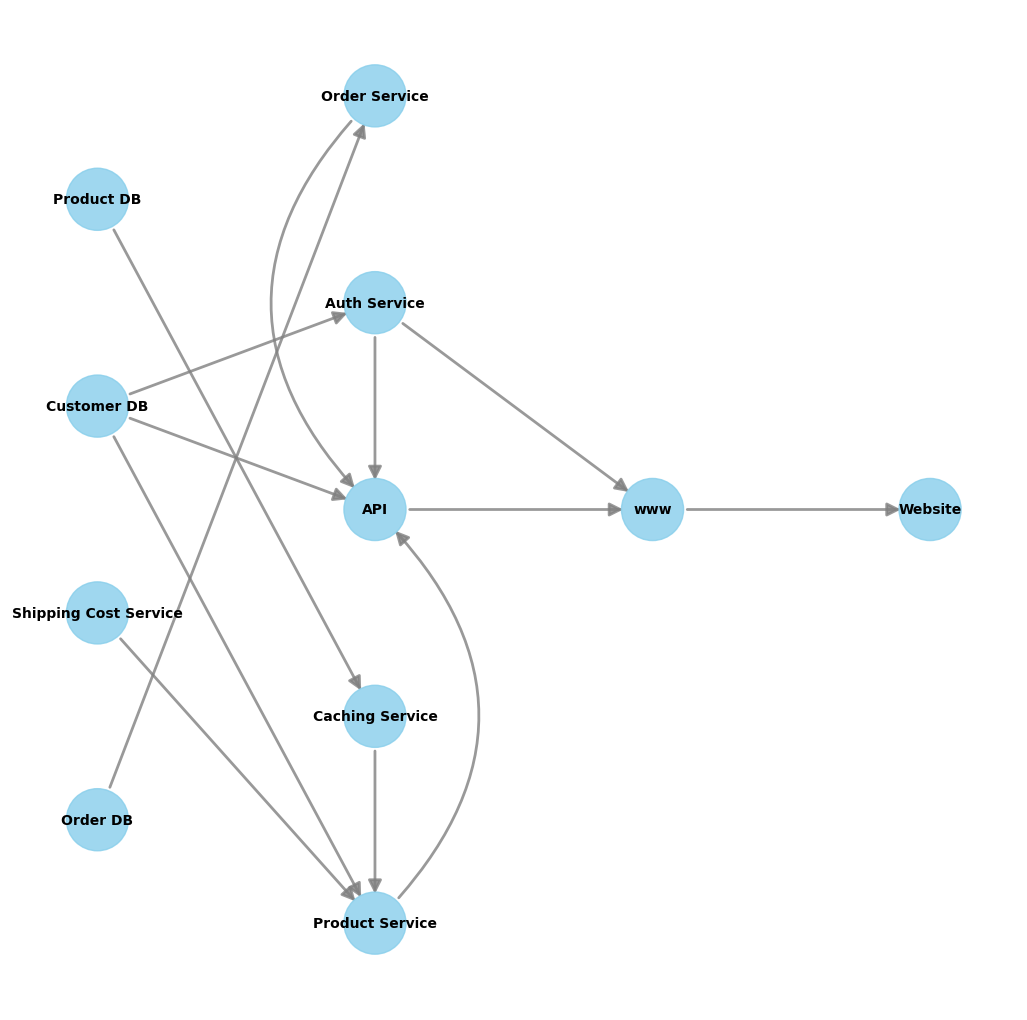

In [5]:
plot(causal_graph, figure_size=[13, 13])

In [13]:
from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)
for node in causal_graph.nodes:
    if len(list(causal_graph.predecessors(node))) > 0:
        causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    else:
        causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(halfnorm))
        

In [3]:
import pandas as pd

normal_data = pd.read_csv("rca_microservice_architecture_latencies.csv")
normal_data.head()


,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0.553608,0.057729,0.153977,0.120217,0.122195,0.391738,0.399664,0.710525,2.103962,2.580403,2.971071
1,0.053393,0.239560,0.297794,0.142854,0.275471,0.545372,0.646370,0.991620,2.932192,3.804571,3.895535
2,0.023860,0.300044,0.042169,0.125017,0.152685,0.574918,0.672228,0.964807,3.106218,4.076227,4.441924
3,0.118598,0.478097,0.042383,0.143969,0.222720,0.618129,0.638179,0.938366,3.217643,4.043560,4.334924
4,0.524901,0.078031,0.031694,0.231884,0.647452,1.081753,0.388506,0.711937,2.793605,3.215307,3.255062


In [4]:

normal_data[['Product DB', 'Customer DB']].sum(axis=1).head()

0    0.611338
1    0.292954
2    0.323904
3    0.596695
4    0.602932
dtype: float64

In [17]:
gcm.fit(causal_model, normal_data)

Fitting causal mechanism of node Order DB: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 283.06it/s]


In [22]:
gcm.evaluate_causal_model(causal_model, normal_data, compare_mechanism_baselines = True)

Evaluating causal mechanisms...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.38it/s]


In [24]:
outlier_data = pd.read_csv("rca_microservice_architecture_anomaly.csv")
print(outlier_data.iloc[0]['Website']-normal_data['Website'].mean())

2.0089554506421723


In [27]:
gcm.config.disable_progress_bars() # to disable print statements when computing Shapley values

median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.attribute_anomalies,
                        causal_model,
                        normal_data,
                        target_node='Website',
                        anomaly_samples=outlier_data),
    num_bootstrap_resamples=10)

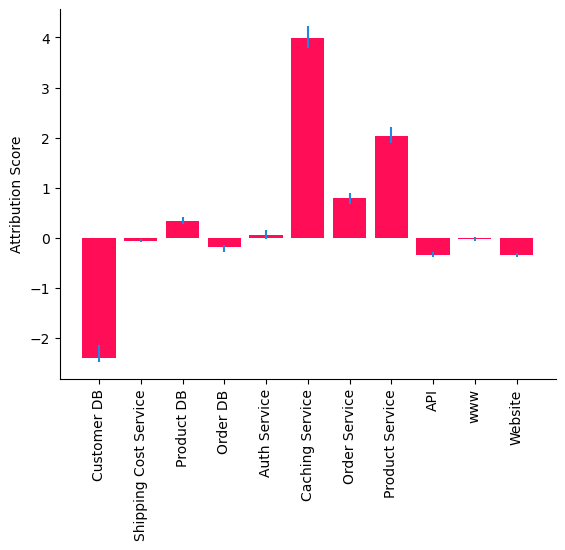

In [28]:
bar_plot(median_attribs, uncertainty_attribs, 'Attribution Score')